In [50]:
import torch.nn as nn
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from glob import glob
from PIL import Image
from torchvision.models.vgg import vgg19
path = './2/img_align_celeba/img_align_celeba'
# 데이터셋
class CelebA(Dataset):
  def __init__(self, path):
    self.images = glob(f'{path}/*.jpg')
    self.low_res_tf =  tf.Compose([
        tf.Resize(32),
        tf.CenterCrop(32),
        tf.ToTensor(),
        tf.Normalize((0.5,0.5,0.5),(0.2,0.2,0.2))
    ])
    self.high_res_tf =  tf.Compose([
        tf.Resize(64),
        tf.CenterCrop(64),
        tf.ToTensor(),
        tf.Normalize((0.5,0.5,0.5),(0.2,0.2,0.2))
    ])
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    # 저화질 이미지는 입력, 고화질 이미지는 정답
    img = Image.open(self.images[idx])
    low_res_img = self.low_res_tf(img)
    high_res_img = self.high_res_tf(img)
    return low_res_img, high_res_img


temp = CelebA(path)
temp2= next(iter(temp))
print('데이터셋 구조 :',temp2[0].shape, temp2[1].shape)

# SRGAN 기본 합성곱 블럭
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResidualBlock, self).__init__()
    # C-B-PR-C-B
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.PReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
    )
  def forward(self, x):
    x_ = x
    x = self.layers(x)
    x = x + x_  # 스킵커넥션인데.. 입려과 출력이 동일한 크기이므로 downsampling은 하지 않는다
    return x

# 업셈플링 층

# sample = torch.randn(1,16,8,8)  # B,C,H,W
# # upscale_factor만큼 가로와세로는 곱해지고.. 채널은 upscale_factor*2으로 나눈값이된다.
# nn.PixelShuffle(upscale_factor=2)(sample).shape   # [1, 4, 16, 16]
class UpSample(nn.Sequential):
  def __init__(self, in_channels, out_channels):
    super(UpSample, self).__init__(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.PixelShuffle(upscale_factor=2),
      nn.PReLU()
    )

# 생성자
# C - ResidualBlock*3 - C - B
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )
    self.residual = nn.Sequential(*[ResidualBlock(64,64) for _ in range(3)])
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.upsample_bolcks = nn.Sequential(
        UpSample(64,256)
    )
    self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)
  def forward(self, x):
    x = self.conv1(x)
    x_ = x  # 스킵커넥션을 위해서 첫번째 합성곱 출력을 저장
    x = self.residual(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = x + x_  # 스킵커넥션
    x = self.upsample_bolcks(x)  # 출력이 256이지만 PixelShuffle의 upscale_factor가 2이므로 2**2 즉 4로 256을 나누면 64
    x = self.conv3(x)
    return x

sample = torch.randn(1,3,32,32)
print('생성자의 결과 모양 :', Generator()(sample).shape)
# 감별자 기본블럭
class DiscBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DiscBlock, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )
  def forward(self, x):
    return self.layers(x)
# 감별자
# C-DiscBlock-Flatt-fc-fc
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU()
    )
    self.disc_blocks =  DiscBlock(64,64)     # 64*32*32
    self.fc1 = nn.Linear(65536, 1024)
    self.fc2 = nn.Linear(1024, 1)
    self.activation = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):  # B, 3, 64,64
    x = self.conv1(x) # 64,64,64
    x = self.disc_blocks(x)    # 64 32 32
    x = torch.flatten(x,start_dim = 1)
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

sample = torch.randn(1,3,64,64)
print('판별자 결과 모양 :', Discriminator()(sample).shape)

# list(vgg19().features.children())[:9]
# 특성추출기(CNN) - 전이학습 vgg19
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    # 사전 학습된 vgg19 정의
    vgg19_model = vgg19(pretrained=True)
    self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:9]) # 9개 층만 사용 why?
  def forward(self, x):
    return self.feature_extractor(x)
# 학습
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# 데이터 로더
dataset = CelebA(path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)  # 배치에 속하지 않은 나머지 데이터들을 사용 안함 drop_last=True
# 생성자와 감별자 정의
G = Generator().to(device)
D = Discriminator().to(device)
# 특성추출기 정의
F = FeatureExtractor().to(device)
F.eval() # eval()이란? 평가모드, Dropout 비활성화 및 BatchNorm 고정
# 옵티마이져 정의
G_optim = Adam(G.parameters(), lr=1e-4)
D_optim = Adam(D.parameters(), lr=1e-4)

데이터셋 구조 : torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
생성자의 결과 모양 : torch.Size([1, 3, 64, 64])
판별자 결과 모양 : torch.Size([1, 1])
cuda


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [2]:
# 학습루프
for epoch in range(1):
  iterator = tqdm(dataloader)
  for low_res_img,hight_res_img in iterator:
    low_res_img = low_res_img.to(device)
    hight_res_img = hight_res_img.to(device)
    G_optim.zero_grad()
    D_optim.zero_grad()
    # 진짜이미지와 가짜이미지의 정답 라벨링
    label_true = torch.ones(8,1).to(device)
    label_fake = torch.zeros(8,1).to(device)
    # 생성자 학습
    fake_hight_img =  G(low_res_img)
    GAN_loss = nn.MSELoss()(D(fake_hight_img), label_true)
    # 생성자가 생성한 고화질이미의 특징 추출
    fake_feature = F(fake_hight_img)
    # 진짜 고화질 이미지의 특징 추출
    real_feature = F(hight_res_img)
    # 데이터가 0~1 사이면 규제는 항상 L1을 적용 why? L2는 제곱이므로 1보다 작은 값을 제곱하면 더 작아짐 -> 기울기 소실
    content_loss = nn.L1Loss()(fake_feature, real_feature) # 0~1사이 데이터이므로 기울기 소실을 막기 위해 L1loss를 사용
    # 생성자 loss
    # content_loss 역활은 이미지의 품질을 유지또는 복원데 기여 GAN_loss의 역활은 생성자가 만든이미지가 진짜처럼 보이는 역활
    # 두개의 스케일이 다르다 content_loss는 L1손실을 적용 mes를 적용한 content_loss 보다 데이터가 클수 있다
    # 확인결과 생성자의성능이 더 뛰어나서 판별자를 잘 속인다... 판별자는 항상 0 또는 1로 판단하는  현상
    # GAN  균형잡힌 학습이 필요
    # 아래처럼. 생성자의 loss값을 임의로 증가
    
    G_loss = GAN_loss * 1e-3 + content_loss # 스케일 고정, GAN loss의 성능이 높아 패널티 부여
    G_loss.backward()
    G_optim.step()
    # 감별자 학습
    real_loss = nn.MSELoss()(D(hight_res_img), label_true)
    fake_loss = nn.MSELoss()(D(fake_hight_img.detach()), label_fake)
    D_loss = (real_loss + fake_loss) / 2
    # 오차 역전파
    D_loss.backward()
    D_optim.step()

    iterator.set_description(f'epoch:{epoch} G_loss: {G_loss.item():.4f} D_loss: {D_loss.item():.4f} D_loss: {D_loss.item():.4f} real loss: {real_loss:.4f} fake loss:{fake_loss:.4f}')

torch.save(G.state_dict(), 'SRGAN_G.pth')
torch.save(D.state_dict(), 'SRGAN_D.pth')

데이터셋 구조 : torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
생성자의 결과 모양 : torch.Size([1, 3, 64, 64])
판별자 결과 모양 : torch.Size([1, 1])
cuda


epoch:0 G_loss: 0.3393 D_loss: 0.0000 D_loss: 0.0000 real loss: 0.0000 fake loss:0.0000: 100%|██████████| 25324/25324 [17:44<00:00, 23.79it/s]


## 평가

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


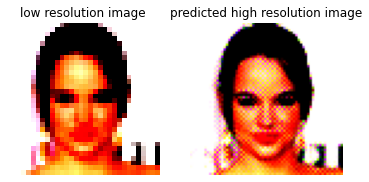

In [19]:
import matplotlib.pyplot as plt
G.load_state_dict(torch.load("SRGAN_G.pth",map_location=device))

with torch.no_grad():
    low_res, high_res = dataset[200]
    
    input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
    
    pred = G(input_tensor)
    pred = pred.squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()
    
    low_res = low_res.permute(1,2,0).numpy()
    
    plt.subplot(1,2,1)
    plt.title('low resolution image')
    plt.imshow(low_res)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(pred)
    plt.title('predicted high resolution image')
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


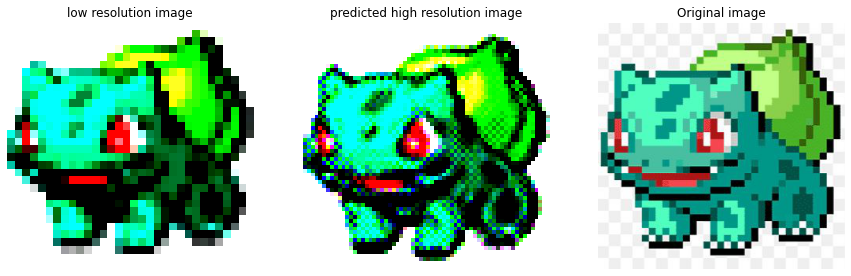

In [49]:
path = '.'
data = CelebA(path)
G.load_state_dict(torch.load("SRGAN_G.pth",map_location=device))
with torch.no_grad():
    idx = 3
    low_res, high_res = data[idx]
    input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
    
    img = glob('./*.jpg')
    org = Image.open(img[idx])
    
    pred = G(input_tensor)
    pred = pred.squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()
    
    low_res = low_res.permute(1,2,0).numpy()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('low resolution image')
    plt.imshow(low_res)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(pred)
    plt.title('predicted high resolution image')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(org)
    plt.title('Original image')
    plt.axis('off')
    plt.show()

In [ ]:
# 해상도를 높여서 

In [71]:
import torch.nn as nn
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from glob import glob
from PIL import Image
from torchvision.models.vgg import vgg19
path = './2/img_align_celeba/img_align_celeba'
# 데이터셋
class CelebA(Dataset):
  def __init__(self, path):
    self.images = glob(f'{path}/*.jpg')
    self.low_res_tf =  tf.Compose([
        tf.Resize(32),
        tf.CenterCrop(32),
        tf.ToTensor(),
        tf.Normalize((0.5,0.5,0.5),(0.2,0.2,0.2))
    ])
    self.high_res_tf =  tf.Compose([
        tf.Resize(64),
        tf.CenterCrop(64),
        tf.ToTensor(),
        tf.Normalize((0.5,0.5,0.5),(0.2,0.2,0.2))
    ])
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    # 저화질 이미지는 입력, 고화질 이미지는 정답
    img = Image.open(self.images[idx])
    low_res_img = self.low_res_tf(img)
    high_res_img = self.high_res_tf(img)
    return low_res_img, high_res_img


temp = CelebA(path)
temp2= next(iter(temp))
print('데이터셋 구조 :',temp2[0].shape, temp2[1].shape)

# SRGAN 기본 합성곱 블럭
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResidualBlock, self).__init__()
    # C-B-PR-C-B
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.PReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
    )
  def forward(self, x):
    x_ = x
    x = self.layers(x)
    x = x + x_  # 스킵커넥션인데.. 입려과 출력이 동일한 크기이므로 downsampling은 하지 않는다
    return x

# 업셈플링 층

# sample = torch.randn(1,16,8,8)  # B,C,H,W
# # upscale_factor만큼 가로와세로는 곱해지고.. 채널은 upscale_factor*2으로 나눈값이된다.
# nn.PixelShuffle(upscale_factor=2)(sample).shape   # [1, 4, 16, 16]
class UpSample(nn.Sequential):
  def __init__(self, in_channels, out_channels):
    super(UpSample, self).__init__(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.PixelShuffle(upscale_factor=2),
      nn.PReLU()
    )

# 생성자
# C - ResidualBlock*3 - C - B
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )
    self.residual = nn.Sequential(*[ResidualBlock(64,64) for _ in range(3)])
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.upsample_bolcks = nn.Sequential(
        UpSample(64,256)
    )
    self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)
  def forward(self, x):
    x = self.conv1(x)
    x_ = x  # 스킵커넥션을 위해서 첫번째 합성곱 출력을 저장
    x = self.residual(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = x + x_  # 스킵커넥션
    x = self.upsample_bolcks(x)  # 출력이 256이지만 PixelShuffle의 upscale_factor가 2이므로 2**2 즉 4로 256을 나누면 64
    x = self.conv3(x)
    return x

sample = torch.randn(1,3,32,32)
print('생성자의 결과 모양 :', Generator()(sample).shape)
# 감별자 기본블럭
class DiscBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DiscBlock, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )
  def forward(self, x):
    return self.layers(x)
# 감별자
# C-DiscBlock-Flatt-fc-fc
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU()
    )
    self.disc_blocks =  DiscBlock(64,64)     # 64*32*32
    self.fc1 = nn.Linear(65536, 1024)
    self.fc2 = nn.Linear(1024, 1)
    self.activation = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):  # B, 3, 64,64
    x = self.conv1(x) # 64,64,64
    x = self.disc_blocks(x)    # 64 32 32
    x = torch.flatten(x,start_dim = 1)
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

sample = torch.randn(1,3,64,64)
print('판별자 결과 모양 :', Discriminator()(sample).shape)

# list(vgg19().features.children())[:9]
# 특성추출기(CNN) - 전이학습 vgg19
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    # vgg19_model = vgg19(pretrained=True)
    # self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:9])
    vgg19_model = vgg19(pretrained=True)
    self.feature_extractor = vgg19_model.features
  def forward(self, x):
    return self.feature_extractor(x)
# 학습
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# 데이터 로더
dataset = CelebA(path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)  # 배치에 속하지 않은 나머지 데이터들을 사용 안함 drop_last=True
# 생성자와 감별자 정의
G = Generator().to(device)
D = Discriminator().to(device)
# 특성추출기 정의
F = FeatureExtractor().to(device)
# F.eval() # eval()이란? 평가모드, Dropout 비활성화 및 BatchNorm 고정
# 옵티마이져 정의
G_optim = Adam(G.parameters(), lr=1e-4)
D_optim = Adam(D.parameters(), lr=1e-4)

데이터셋 구조 : torch.Size([3, 32, 32]) torch.Size([3, 64, 64])
생성자의 결과 모양 : torch.Size([1, 3, 64, 64])
판별자 결과 모양 : torch.Size([1, 1])
cuda


In [72]:
# 학습루프
for epoch in range(1):
  iterator = tqdm(dataloader)
  for low_res_img,hight_res_img in iterator:
    low_res_img = low_res_img.to(device)
    hight_res_img = hight_res_img.to(device)
    G_optim.zero_grad()
    D_optim.zero_grad()
    # 진짜이미지와 가짜이미지의 정답 라벨링
    label_true = torch.ones(8,1).to(device)
    label_fake = torch.zeros(8,1).to(device)
    # 생성자 학습
    fake_hight_img =  G(low_res_img)
    GAN_loss = nn.MSELoss()(D(fake_hight_img), label_true)
    # 생성자가 생성한 고화질이미의 특징 추출
    fake_feature = F(fake_hight_img)
    # 진짜 고화질 이미지의 특징 추출
    real_feature = F(hight_res_img)
    # 데이터가 0~1 사이면 규제는 항상 L1을 적용 why? L2는 제곱이므로 1보다 작은 값을 제곱하면 더 작아짐 -> 기울기 소실
    content_loss = nn.L1Loss()(fake_feature, real_feature) # 0~1사이 데이터이므로 기울기 소실을 막기 위해 L1loss를 사용
    # 생성자 loss
    # content_loss 역활은 이미지의 품질을 유지또는 복원데 기여 GAN_loss의 역활은 생성자가 만든이미지가 진짜처럼 보이는 역활
    # 두개의 스케일이 다르다 content_loss는 L1손실을 적용 mes를 적용한 content_loss 보다 데이터가 클수 있다
    # 확인결과 생성자의성능이 더 뛰어나서 판별자를 잘 속인다... 판별자는 항상 0 또는 1로 판단하는  현상
    # GAN  균형잡힌 학습이 필요
    # 아래처럼. 생성자의 loss값을 임의로 증가
    
    G_loss = GAN_loss * 1e-3 + content_loss # 스케일 고정, GAN loss의 성능이 높아 패널티 부여
    G_loss.backward()
    G_optim.step()
    # 감별자 학습
    real_loss = nn.MSELoss()(D(hight_res_img), label_true)
    fake_loss = nn.MSELoss()(D(fake_hight_img.detach()), label_fake)
    D_loss = (real_loss + fake_loss) / 2
    # 오차 역전파
    D_loss.backward()
    D_optim.step()

    iterator.set_description(f'epoch:{epoch} G_loss: {G_loss.item():.4f} D_loss: {D_loss.item():.4f} D_loss: {D_loss.item():.4f} real loss: {real_loss:.4f} fake loss:{fake_loss:.4f}')

torch.save(G.state_dict(), 'SRGAN_G_vggall.pth')
torch.save(D.state_dict(), 'SRGAN_D_vggall.pth')

epoch:0 G_loss: 0.2100 D_loss: 0.0000 D_loss: 0.0000 real loss: 0.0000 fake loss:0.0000: 100%|██████████| 25324/25324 [23:18<00:00, 18.11it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


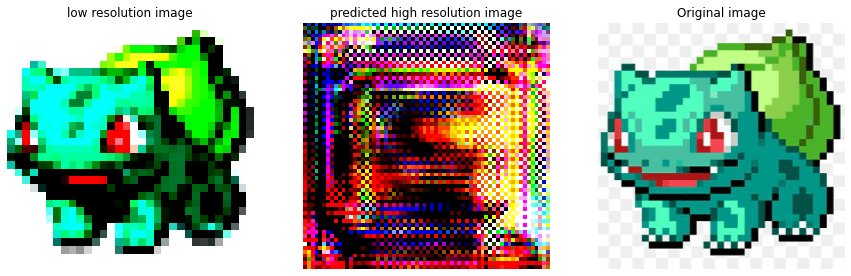

In [74]:
path = '.'
data = CelebA(path)
G.load_state_dict(torch.load("SRGAN_G_vggall.pth",map_location=device))
with torch.no_grad():
    idx = 0
    low_res, high_res = data[idx]
    input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
    
    img = glob('./*.jpg')
    org = Image.open(img[idx])
    
    pred = G(input_tensor)
    pred = pred.squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()
    
    low_res = low_res.permute(1,2,0).numpy()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('low resolution image')
    plt.imshow(low_res)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(pred)
    plt.title('predicted high resolution image')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(org)
    plt.title('Original image')
    plt.axis('off')
    plt.show()

## 512 x 512 이미지로 학습하기

In [75]:
import os

# 현재 작업 디렉토리 확인
print("Current directory:", os.getcwd())

# 상위 디렉터리로 이동
os.chdir("..")
os.chdir("..")
os.chdir("test")

# 상위 디렉터리에서 파일 목록 출력
print("Files in parent directory:", os.listdir())

Current directory: /home/jovyan
Files in parent directory: ['open.tar.xz', 'open', 'saved_models', 'submission', 'down']


In [94]:
import torch.nn as nn
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from glob import glob
from PIL import Image
from torchvision.models.vgg import vgg19

path = './open/train_gt'

# 데이터셋
class CelebA(Dataset):
    def __init__(self, path):
        self.images = glob(f'{path}/*.png')
        self.low_res_tf = tf.Compose([
            tf.Resize(128),  # 저해상도 크기를 128로 변경
            tf.CenterCrop(128),
            tf.ToTensor(),
            tf.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
        ])
        self.high_res_tf = tf.Compose([
            tf.Resize(512),  # 고해상도 크기를 512로 변경
            tf.CenterCrop(512),
            tf.ToTensor(),
            tf.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 저화질 이미지는 입력, 고화질 이미지는 정답
        img = Image.open(self.images[idx])
        low_res_img = self.low_res_tf(img)
        high_res_img = self.high_res_tf(img)
        return low_res_img, high_res_img


temp = CelebA(path)
temp2 = next(iter(temp))
print('데이터셋 구조 :', temp2[0].shape, temp2[1].shape)

# SRGAN 기본 합성곱 블럭
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        # C-B-PR-C-B
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        x_ = x
        x = self.layers(x)
        x = x + x_  # 스킵 커넥션 (입력과 출력 크기 동일)
        return x


# 업샘플링 층
class UpSample(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor=2),  # 가로/세로 크기 2배 증가
            nn.PReLU()
        )


# 생성자
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.residual = nn.Sequential(*[ResidualBlock(64, 64) for _ in range(3)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # 업샘플링 블록을 두 번 사용하여 최종 해상도를 맞춤 (128 -> 256 -> 512)
        self.upsample_blocks = nn.Sequential(
            UpSample(64, 256), 
            UpSample(64, 256)
        )
        
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.conv1(x)
        x_ = x  # 스킵 커넥션을 위해 첫 번째 합성곱 출력을 저장
        x = self.residual(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + x_  # 스킵 커넥션
        x = self.upsample_blocks(x)  
        x = self.conv3(x)
        return x


sample = torch.randn(1, 3, 128, 128)  # 입력 크기: BxCxHxW (저해상도: 128x128)
print('생성자의 결과 모양 :', Generator()(sample).shape)


# 감별자 기본 블록
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.layers(x)


# 감별자
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 입력 크기에 맞게 조정된 구조 (512x512 이미지를 처리 가능하도록 설계)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64,
                      kernel_size=3,
                      padding=1),
            nn.LeakyReLU()
        )
        
        # 여러 DiscBlock을 추가하여 다운샘플링 수행 (최종적으로 충분히 작은 특성맵 생성)
        self.disc_blocks = nn.Sequential(
            DiscBlock(64, 128),   # 출력: Bx128x256x256
            DiscBlock(128, 256),  # 출력: Bx256x128x128
            DiscBlock(256, 512),  # 출력: Bx512x64x64
            DiscBlock(512, 512)   # 출력: Bx512x32x32
        )
        
        # Fully Connected Layers for Classification
        self.fc1 = nn.Linear(512 * (32 * 32), 1024)  
        self.fc2 = nn.Linear(1024, 1)
        
    def forward(self, x):  
        x = self.conv1(x) 
        x = self.disc_blocks(x)    
        
        # Flatten and pass through fully connected layers
        x = torch.flatten(x,start_dim=1) 
        x = torch.relu(self.fc1(x))
        
        return torch.sigmoid(self.fc2(x))


sample = torch.randn(1, 3, 512, 512)  
print('판별자 결과 모양 :', Discriminator()(sample).shape)


# 특성 추출기(CNN) - 전이 학습 VGG19 사용
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        
        vgg19_model = vgg19(pretrained=True)  
        
        # VGG19의 초기 레이어 일부만 사용 (특징 추출용)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:9])  

    def forward(self,x):
         return self.feature_extractor(x)


# 학습 준비 단계
from tqdm import tqdm
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# 데이터 로더 정의 (배치 크기와 데이터셋 경로 유지)
dataset = CelebA(path)
dataloader = DataLoader(dataset,
                        batch_size=8,
                        shuffle=True,
                        drop_last=True)

# 생성자와 감별자 정의 및 GPU 이동
G = Generator().to(device)
D = Discriminator().to(device)

# 특성 추출기 정의 및 평가 모드 설정 (Dropout 비활성화 및 BatchNorm 고정)
F = FeatureExtractor().to(device)
F.eval()

# 옵티마이저 정의
G_optim = Adam(G.parameters(), lr=1e-4)
D_optim = Adam(D.parameters(), lr=1e-4)

데이터셋 구조 : torch.Size([3, 128, 128]) torch.Size([3, 512, 512])
생성자의 결과 모양 : torch.Size([1, 3, 512, 512])
판별자 결과 모양 : torch.Size([1, 1])
cuda


In [86]:
# 학습루프
for epoch in range(1):
  iterator = tqdm(dataloader)
  for low_res_img,hight_res_img in iterator:
    low_res_img = low_res_img.to(device)
    hight_res_img = hight_res_img.to(device)
    G_optim.zero_grad()
    D_optim.zero_grad()
    # 진짜이미지와 가짜이미지의 정답 라벨링
    label_true = torch.ones(8,1).to(device)
    label_fake = torch.zeros(8,1).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    
    # 생성자 학습
    fake_hight_img =  G(low_res_img)
    GAN_loss = criterion(D(fake_hight_img), label_true)
    # 생성자가 생성한 고화질이미의 특징 추출
    fake_feature = F(fake_hight_img)
    # 진짜 고화질 이미지의 특징 추출
    real_feature = F(hight_res_img)
    # 데이터가 0~1 사이면 규제는 항상 L1을 적용 why? L2는 제곱이므로 1보다 작은 값을 제곱하면 더 작아짐 -> 기울기 소실
    content_loss = nn.L1Loss()(fake_feature, real_feature) # 0~1사이 데이터이므로 기울기 소실을 막기 위해 L1loss를 사용
    # 생성자 loss
    # content_loss 역활은 이미지의 품질을 유지또는 복원데 기여 GAN_loss의 역활은 생성자가 만든이미지가 진짜처럼 보이는 역활
    # 두개의 스케일이 다르다 content_loss는 L1손실을 적용 mes를 적용한 content_loss 보다 데이터가 클수 있다
    # 확인결과 생성자의성능이 더 뛰어나서 판별자를 잘 속인다... 판별자는 항상 0 또는 1로 판단하는  현상
    # GAN  균형잡힌 학습이 필요
    # 아래처럼. 생성자의 loss값을 임의로 증가
    
    gan_weight = 1e-3
    G_loss = GAN_loss * gan_weight + content_loss # 스케일 고정, GAN loss의 성능이 높아 패널티 부여
    G_loss.backward()
    G_optim.step()
    
    # 감별자 학습
    real_loss = criterion(D(hight_res_img), label_true)
    fake_loss = criterion(D(fake_hight_img.detach()), label_fake)
    D_loss = (real_loss + fake_loss) / 2

    # 오차 역전파
    D_loss.backward()
    D_optim.step()

    iterator.set_description(f'epoch:{epoch} G_loss: {G_loss.item():.4f} D_loss: {D_loss.item():.4f} real loss: {real_loss:.4f} fake loss:{fake_loss:.4f}')

torch.save(G.state_dict(), 'SRGAN_G_512.pth')
torch.save(D.state_dict(), 'SRGAN_D_512.pth')

epoch:0 G_loss: 0.8647 D_loss: 0.6931 real loss: 0.6931 fake loss:0.6931: 100%|██████████| 3700/3700 [1:38:38<00:00,  1.60s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


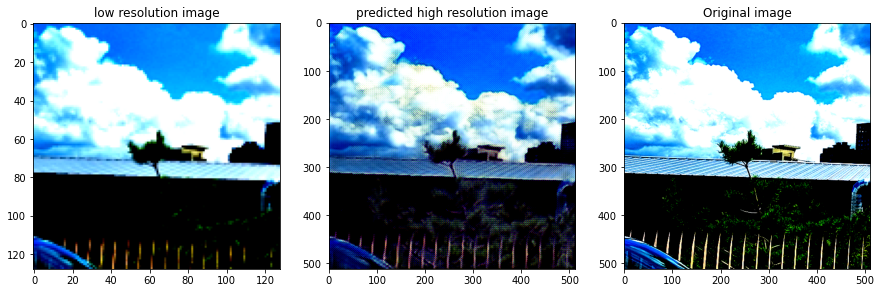

In [108]:
import matplotlib.pyplot as plt
G.load_state_dict(torch.load("SRGAN_G_512.pth",map_location=device))

with torch.no_grad():
    low_res, high_res = dataset[0]
    
    input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
    
    pred = G(input_tensor)
    pred = pred.squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()
    
    low_res = low_res.permute(1,2,0).numpy()
    high_res = high_res.permute(1,2,0).numpy()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('low resolution image')
    plt.imshow(low_res)

    plt.subplot(1,3,2)
    plt.imshow(pred)
    plt.title('predicted high resolution image')

    plt.subplot(1,3,3)
    plt.imshow(high_res)
    plt.title('Original image')

    plt.show()

In [ ]:
path = '.'
data = CelebA(path)
G.load_state_dict(torch.load("SRGAN_G_vggall.pth",map_location=device))
with torch.no_grad():
    idx = 0
    low_res, high_res = data[idx]
    input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
    
    img = glob('./*.jpg')
    org = Image.open(img[idx])
    
    pred = G(input_tensor)
    pred = pred.squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()
    
    low_res = low_res.permute(1,2,0).numpy()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('low resolution image')
    plt.imshow(low_res)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(pred)
    plt.title('predicted high resolution image')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(org)
    plt.title('Original image')
    plt.axis('off')
    plt.show()